<a href="https://colab.research.google.com/github/YeweiYuan/Quantum-Pricing/blob/main/qfin_phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

功能性函数
---

---
辅助工具

In [ ]:
!pip install pyqpanda

In [ ]:
import pyqpanda.pyQPanda as pq
import math
import matplotlib.pyplot as plt
import numpy as np

- 运算函数

In [ ]:
#在编辑函数的时候近可能把返回值返回circuit类型便于直接在程序中插入，输入变量根据功能大多为qubit或circuit

def QG(qbits,G=pq.H):  #批量对qbits进行gate操作,默认G初始化为哈达玛门//注意qbits类型需要是列表注意这里一开始circuit=pq.create_empty_circuit()传参circuit会报错
  circuit = pq.create_empty_circuit()
  if type(G) == type(pq.H):  
    for i in range(len(qbits)):
      circuit.insert(G(qbits[i]))
  return circuit

def power(circuit,k):  #进行k次circuit操作
  circuitk = pq.create_empty_circuit()
  for j in range(k):
    circuitk.insert(circuit)
  return circuitk

def Toffoli(qbit1,qbit2,qbit3): #Toffoli门
  circuit = pq.create_empty_circuit()
  circuit.insert(pq.X(qbit3).control([qbit1,qbit2]))
  return circuit

def Qor(qbit1,qbit2,qbit3):  #对qbit1,qbit2或运算,运算结果输出到qbit3
  circuit = pq.create_empty_circuit()
  circuit.insert(QG([qbit1,qbit2,qbit3],pq.X))\
  .insert(Toffoli(qbit1,qbit2,qbit3))\
  .insert(QG([qbit1,qbit2],pq.X))
  return circuit

def Qand(qbit1,qbit2,qbit3):  #对qbit1,qbit2与运算,运算结果输出到qbit3
  circuit = pq.create_empty_circuit()
  circuit.insert(QG([qbit1,qbit2,qbit3],pq.X))\
  .insert(Toffoli(qbit1,qbit2,qbit3))\
  .insert(QG([qbit1,qbit2],pq.X))
  return circuit

In [ ]:
#检验X^n门，同时对所有比特操作  
m_machine = pq.init_quantum_machine(pq.QMachineType.CPU)
n=2
qlist = m_machine.qAlloc_many(n)

qprog = pq.QProg()
qprog.insert(power(QG(qlist,pq.X),3)) #3次X应该最后结果等同于1次,即所有比特变为1

res = m_machine.prob_run_tuple_list(qprog,qlist,-1)
print(res)

pq.draw_qprog(qprog)
pq.finalize()

{'00': 0.0, '01': 0.0, '10': 0.0, '11': 1.0}


- 功能函数

In [ ]:
def phasee(machine,qbits,prog,operator=QG,m=2): #相位估计，输入qbits,估计的算子，先前的量子程序，和用于相位估计的比特数
  anc = machine.qAlloc_many(m)
  clist = machine.cAlloc_many(m)
  for i in range(m):
    prog.insert(pq.H(anc[i]))
    prog.insert(power(operator(qlist,G=pq.X),2**i).control(anc[i]))
  
  prog.insert(pq.QFT(anc).dagger())
  prog.insert(pq.measure_all(anc,clist))
  result = machine.run_with_configuration(prog,clist,1000)
  print(result)
  pq.finalize()

def to_zero(machine,qbits,cbits=0,flag=0):    #把qbits归零（复位），可以用在下面的函数或者一些调试，也可以在一些程序里重复利用qubit,flag为1时为变1 QwQnmd为什么不能把测量写进circuit
  circuit = pq.create_empty_circuit()
  ancprog = pq.create_empty_qprog()
  if cbits == 0:
    cbits = machine.cAlloc_many(len(qbits))
  ancprog.insert(pq.measure_all(qbits,cbits))
  res = machine.run_with_configuration(prog,cbits,1)
  
  for i in range(len(qbits)):
    if int(list(result.keys())[0][i]) == 1-flag:
      circuit.insert(QG([qbits[len(m_qlist)-1-i]],pq.X)) #这里有个坑，观测输出的二进制数是按逆序来的要转回来
  return circuit

def int_to_qbits(k,qbits): #把一整数转化为二进制编入qibits,可以在位不齐的时候用0补全，这里应该要求输入的qbits全0 注意量子比特第一位是代表2^0 感觉写电路时把一个qbit作为参数很困难，因为qbit好像需要实际先生成不然不能做参数很不方便
  circuit = pq.create_empty_circuit()
  k_bin = bin(k)[2:]             #注意返回的是str
  for i in range(len(k_bin)):
    if k_bin[i]=='1':
     circuit.insert(pq.X(qbits[len(k_bin)-1-i]))
  return circuit

def compare_qc(qbits,comparor,k,machine): #把qubits的值不进行观测地与整数k进行比较，输出结果到comparor(量子态为1则k小或相等,0则k大)，c仍继续作为电路一部分
  circuit = pq.create_empty_circuit()
  c = comparor
  if k == 0:
    circuit.insert(pq.X(c[0]))
    return circuit

  k_bin = list(bin(k)[2:])  #k是用经典比特储存的，下面用经典的if进行控制，但是如果用量子比特则对应control-Gate(Circuit)，所以实际上比较两个量子形式的整数更为复杂，所以我们直接和整数k比较，再单独写量子形式的比较
  if len(qbits) < len(k_bin):  #你都没人家k长
    return circuit
  elif len(qbits) > len(k_bin): #k长度不够则用0补齐
    k_bin = ['0']*(len(qbits)-len(k_bin))+k_bin

  n = len(qbits)
  anc = machine.qAlloc_many(len(qbits)) #anc用于减法借位
  if k_bin[n-1] == '1':
    circuit.insert(pq.CNOT(qbits[0],anc[0]))
  for i in range(1,n):
    j = n-i-1            #一定注意str和qlist的index相反
    if k_bin[j] == '0':
      circuit.insert(Toffoli(qbits[i],anc[i-1],anc[i]))
    elif k_bin[j] == '1':
      circuit.insert(Qor(qbits[i],anc[i-1],anc[i]))

  circuit.insert(pq.CNOT(anc[len(qbits)-1],c[0]))  #注意c是个list......
  
  circuit.insert(to_zero(machine,anc)) #anc复位
  return circuit    

'''
def compare_qq(qbits,qbits_c,machine): #把qubits的值不进行观测地与另一量子列表qbits_c进行比较，输出结果到c(量子态为1则k小或相等,0则k大)，c仍继续作为电路一部分
  circuit = pq.create_empty_circuit()
  c = machine.qAlloc_many(1)

  if len(qbits) < len(qbits_c):
    qbits = machine.qAlloc_many((len(qbits_c)-len(qbits)))
  elif len(qbits) > len(qbits_c): 
    qbits_c = ['0']*(len(qbits)-len(qbits_c))+qbits_c

  n = len(qbits)
  anc = machine.qAlloc_many(len(qbits)) #anc用于减法借位

  circuit.insert(pq.CNOT(qbits[0],anc[0]))
  for i in range(1,n):
    #怎么让qbits_c control到两个电路呢。。。。。

  circuit.insert(pq.CNOT(anc[len(qbits)],c))
  
  circuit.insert(to_zero(machine,anc)) #anc复位
  return c    #因为这个函数要的就是结果c而且并不改变原qbits所以返回值是c
'''

In [ ]:
#比特测量一个比较好的方式，Measure不好用
m_machine = pq.init_quantum_machine(pq.QMachineType.CPU) 

m_qlist = m_machine.qAlloc_many(3)
m_clist = m_machine.cAlloc_many(3)
prog = pq.QProg()
prog.insert(QG([m_qlist[0]],pq.X))

prog.insert(pq.measure_all([m_qlist[1]],[m_clist[1]])) #这里只测量第二个比特

result = m_machine.run_with_configuration(prog, [m_clist[1]], 1000)
print(result)

prog.insert(pq.measure_all([m_qlist[0]],[m_clist[0]])) #这里只测量第一个比特
result = m_machine.run_with_configuration(prog, [m_clist[0]], 1000)
print(result)

{'0': 1000}
{'1': 1000}


In [ ]:
#检验相位估计
m_machine = pq.init_quantum_machine(pq.QMachineType.CPU)
n=1
qlist = m_machine.qAlloc_many(n)

qprog = pq.QProg()
qprog.insert(QG(qlist,G=pq.H)).insert(QG(qlist,G=pq.Z))

phasee(m_machine,qlist,qprog,m=4)

{'0001': 408, '0011': 52, '0101': 24, '0111': 12, '1001': 22, '1011': 22, '1101': 55, '1111': 405}


In [ ]:
#检验复位
m_machine = pq.init_quantum_machine(pq.QMachineType.CPU) 

m_qlist = m_machine.qAlloc_many(3)
m_clist = m_machine.cAlloc_many(3)
prog = pq.QProg()
prog.insert(QG([m_qlist[0]],pq.X))

prog.insert(pq.measure_all(m_qlist,m_clist))
result = m_machine.run_with_configuration(prog, m_clist, 100)
print(result)

prog.insert(to_zero(m_machine,m_qlist))

prog.insert(pq.measure_all(m_qlist,m_clist))
result = m_machine.run_with_configuration(prog, m_clist, 100)
print(result)

{'001': 100}
{'000': 100}


In [ ]:
#检验整数encode
m_machine = pq.init_quantum_machine(pq.QMachineType.CPU) 

m_qlist4 = m_machine.qAlloc_many(3)
m_qlist2 = m_machine.qAlloc_many(3)
m_clist = m_machine.cAlloc_many(3)
prog = pq.QProg()
prog.insert(int_to_qbits(4,m_qlist4))

circuit = pq.create_empty_circuit()
k_bin = bin(2)[2:]             #注意返回的是str
for i in range(len(k_bin)):
  if k_bin[i]=='1':
    circuit.insert(pq.X(m_qlist2[len(k_bin)-1-i]))
prog.insert(circuit)

prog.insert(pq.measure_all(m_qlist4,m_clist))
result4 = m_machine.run_with_configuration(prog, m_clist, 100)
print(result4)

prog.insert(pq.measure_all(m_qlist2,m_clist))
result2 = m_machine.run_with_configuration(prog, m_clist, 100)
print(result2)

{'100': 100}
{'010': 100}


In [ ]:
#检测比较器(量子位和给定整数比较)
m_machine = pq.init_quantum_machine(pq.QMachineType.CPU) 

m_qlist = m_machine.qAlloc_many(3)
m_clist = m_machine.cAlloc_many(1)

prog = pq.QProg()
comparor = m_machine.qAlloc_many(1)

prog.insert(int_to_qbits(6,m_qlist))
prog.insert(compare_qc(m_qlist,comparor,3,m_machine)) #k=3,比6小应该得到量子态1

prog.insert(pq.measure_all(comparor,m_clist))

res = m_machine.run_with_configuration(prog,m_clist,1000)

if list(res.keys())[0] == '1':
  print('6>3!')

else:
  print('你又出bug了')

6>3!


量子期权定价
---



---
蒙特卡罗方法和bsm



In [ ]:
import numpy as np
from scipy.stats import norm
from numpy.random import standard_normal
import matplotlib.pyplot as plt

In [ ]:
class Sampling:
  def __init__(self,N=10000,T=365,S_0=5,K=5.5,Rate=0.04,Sigma=0.24,steps=100): #初始化一年的股票欧式期权，标的资产股票价格为5元，期权执行价格为6元，年化无风险利率和年化波动率分别为4%和24%，模拟10000次
    self.N = N # sample size
    self.T = T/365 # time
    self.S_0 = S_0 # init price
    self.Rate = Rate # rate
    self.Sigma = Sigma # volatility
    self.K = K # strike price
    self.steps = steps #二叉树取节点数默认1年100次

  def callMonteCarlo(self): #蒙特卡罗法，看涨期权
    z = standard_normal(self.N)
    S_t = self.S_0*np.exp((self.Rate-0.5*self.Sigma**2)*self.T+self.Sigma*z*np.sqrt(self.T))
    call = np.maximum(0,S_t-self.K)
    res = sum(call)*(np.exp(-self.Rate*self.T))/self.N
    return res
  
  def callBSM(self): #BSM模型，看涨期权
    d1 = (np.log(self.S_0/self.K)+(self.Rate*self.T))/ \
    (self.Sigma*np.sqrt(self.T))+0.5*self.Sigma*np.sqrt(self.T)
    d2 = d1-self.Sigma*np.sqrt(self.T)
    call = self.S_0*norm.cdf(d1,0.0,1.0)-self.K*np.exp(-self.Rate*self.T)*norm.cdf(d2,0.0,1.0)
    return call

  def callBin(self): #二叉树模型，看涨期权
    u=np.exp(self.Sigma*np.sqrt(self.T/self.steps))
    d=1/u
    P=(np.exp(self.Rate*self.T/self.steps)-d)/(u-d)
    S_t = [[] for i in range(self.steps+1)]
    call = [[] for i in range(self.steps+1)] 
    S_t[0]=self.S_0*d**self.steps #最后一行最后一列的股票价格
    call[0]=np.maximum(S_t[0]-self.K,0) #最后一行最后一列的期权价值
    for i in range(1,self.steps+1):
      S_t[i]=S_t[i-1]*(u**2) #计算最后一列的股票价格
      call[i]=np.maximum(S_t[i]-self.K,0) #计算最后一列的期权价值
    for j in range(self.steps,0,-1): #逐个节点往前计算
      for i in range(0,j):
        call[i]=(P*call[i+1]+(1-P)*call[i])/np.exp(self.Rate*self.T/self.steps)
    return call[0]


In [ ]:
test = Sampling()

In [ ]:
print('MonteCarlo: %f \nBSM: %f \nBIN: %f'%(test.callMonteCarlo(),test.callBSM(),test.callBin()))

MonteCarlo: 0.364538 
BLM: 0.361912 
BIN: 0.360706


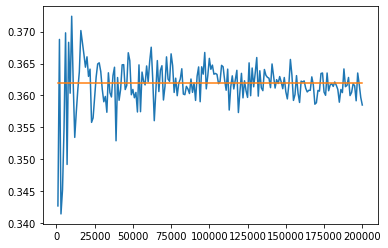

In [ ]:
MC = []
for i in range(1000,201000,1000):
  test = Sampling(N=i)
  MC.append(test.callMonteCarlo())
BSM = [test.callBSM()]*200
plt.plot(range(1000,201000,1000),MC)
plt.plot(range(1000,201000,1000),BSM)

---
量子方法

In [ ]:
!pip install pyqpanda

     |████████████████████████████████| 20.8MB 1.6MB/s 


In [ ]:
import pyqpanda.pyQPanda as pq
import math

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from numpy.random import standard_normal

In [ ]:
class Qsampling:
  def __init__(self,N=5,M=3,T=365,S_0=5,K=5.5,Rate=0.04,Sigma=0.24,machineType=pq.QMachineType.CPU,c=0.1): #3个用于拟合分布的qubits(2^(-n)的误差)，3个用于相位估计的qubits，1个ancilla qubit
    self.N = N
    self.M = M
    self.T = T/365 # time
    self.S_0 = S_0 # init price
    self.Rate = Rate # rate
    self.Sigma = Sigma # volatility
    self.K = K # strike price
    
    self.m_machine = pq.init_quantum_machine(machineType)
    self.m_qlist = self.m_machine.qAlloc_many(N)    #记录股价的N个qubits
    self.AE_qlist = self.m_machine.qAlloc_many(M)    #相位估计的M个ancilla qubits
    self.m_clist = self.m_machine.cAlloc_many(M)  
    self.m_prog = pq.QProg()
    self.c = c #s an additional scaling parameter

    self.comparator = self.m_machine.qAlloc_many(1) 
    self.oqbit = self.m_machine.qAlloc_many(1)   #被用于振幅估计的最后一个比特

  def __del__(self):
    pq.destroy_quantum_machine(self.m_machine)

  def sample(self):  #使用sample函数对布朗运动进行采样 S_T = self.S_0*np.exp((self.Rate-0.5*self.Sigma**2)*self.T+self.Sigma*w)
    w_max = np.sqrt(self.T)*3 #首先进行布朗运动W的取样，这里取3倍标准差涵盖99.7的正态分布 
    w_min = -w_max  
    x_max = self.S_0*np.exp(self.Sigma*w_max+(self.Rate-0.5*self.Sigma**2)*self.T) #S_t服从对数正态分布所以我们这个量子振幅应该模拟出来一个对数正态分布（论文1里用的正态分布再在电路中进行指数运算等，这里参考ibm直接模拟对数正态分布）
    x_min = self.S_0*np.exp(self.Sigma*w_min+(self.Rate-0.5*self.Sigma**2)*self.T)
    delta = (x_max-x_min)/(2**self.N-1)
    x_j = []
    w_j = []
    p_j = []
    for j in range(2**self.N):
      x_j.append(x_min+j*delta)
      w_j.append((np.log((x_min+j*delta)/self.S_0)-(self.Rate-0.5*self.Sigma**2)*self.T)/self.Sigma)
      p_j.append(norm.pdf(w_j[j]))
      
    p_j = np.array(p_j)/sum(p_j)

    '''
    未完成的手动量子态振幅编码程序
    p_mk = [[] for i in range(self.N)]
    for m in range(self.N):
      for k in range(2**(m+1)):
        p_mk[m].append(sum(p_j[k*2**(self.N-m-1):(k+1)*2**(self.N-m-1)]))
 
    theta_mk = [[] for i in range(self.N-1)]
    for m in range(self.N-1):
      for k in range(2**(m+1)):
        theta_mk[m].append(np.arccos(np.sqrt(p_mk[m+1][2*k]/p_mk[m][k])))
    '''
    cir_encode = pq.amplitude_encode(self.m_qlist,p_j)
    self.m_prog.insert(cir_encode)

    res = self.m_machine.prob_run_tuple_list(self.m_prog,qlist[0:self.N],-1)
    
    k_index = int((self.K-x_min)/delta) #向下取整
    print(k_index)
    #plt.plot(x_j,p_j)
    #plt.plot(x_j,list(res.values()))
    return x_j,p_j,k_index #返回取样点和取样点的概率
  

  def expectation(self): #使用expectation函数把采样的布朗运动映射到对应的期权价格并给出期望
    prog.insert(compare_qc(self.m_qlist,self.comparor,3,self.m_machine))
    x_j,p_j,k_index = self.sample()

    '''
    v_x = []
    for x in x_j:
      v_x.append(max(0,self.S_0*np.exp((self.Rate-0.5*self.Sigma**2)*self.T+self.Sigma*x)-self.K))
    print(v_x)
    这里文献1试图把v_x编入量子电路中直接测量，但是需要各种量子电路上的算数运算，他也没给具体实现方法，想了一整天没想出来怎么操作
    '''
    g_0 = math.pi/4 *（1-self.c）    #c是一个缩放率
    
    g_i = []
    for i in range(2**self.N):
        if i < k_index:
            g_i.append(g_0)
        else:
            g_i.append((math.pi/2*self.c(i-K_index))/(2**self.N-1-k_index))  #初始化相位角

    self.m_prog.insert(pq.RY(self.oqbit,g_0)))
    for q_i in self.m_qlist:
      i = 0
      RY(qubit,g_i[i]*(2**i)).control([self.comparator,q_i])
      i+=1
    

   def qbin(self):
    print('uncompleted')


11


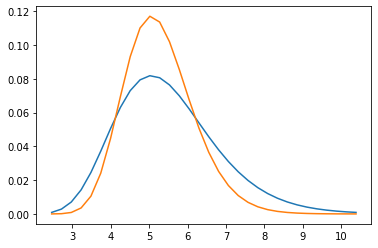

In [ ]:
#对对数正态分布的取样情况，能完成但是发现误差挺大
Qtest = Qsampling()